In [1]:
# =======================
# 2. Install & Import
# =======================
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import load_img, img_to_array
print(" All libraries imported successfully!")

 All libraries imported successfully!


In [2]:
# =======================
# 3. Dataset Paths
# =======================
train_dir = r"C:\Users\Hp\Desktop\dataset\margeDataset\train"
val_dir   = r"C:\Users\Hp\Desktop\dataset\margeDataset\valid"
test_dir  = r"C:\Users\Hp\Desktop\dataset\margeDataset\test"


In [3]:
# =======================
# 4. Data Generators
# =======================
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())


Found 20597 images belonging to 20 classes.
Found 5885 images belonging to 20 classes.
Found 2943 images belonging to 20 classes.


C:\Users\Hp\AppData\Local\Temp\ipykernel_13668\3350938150.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


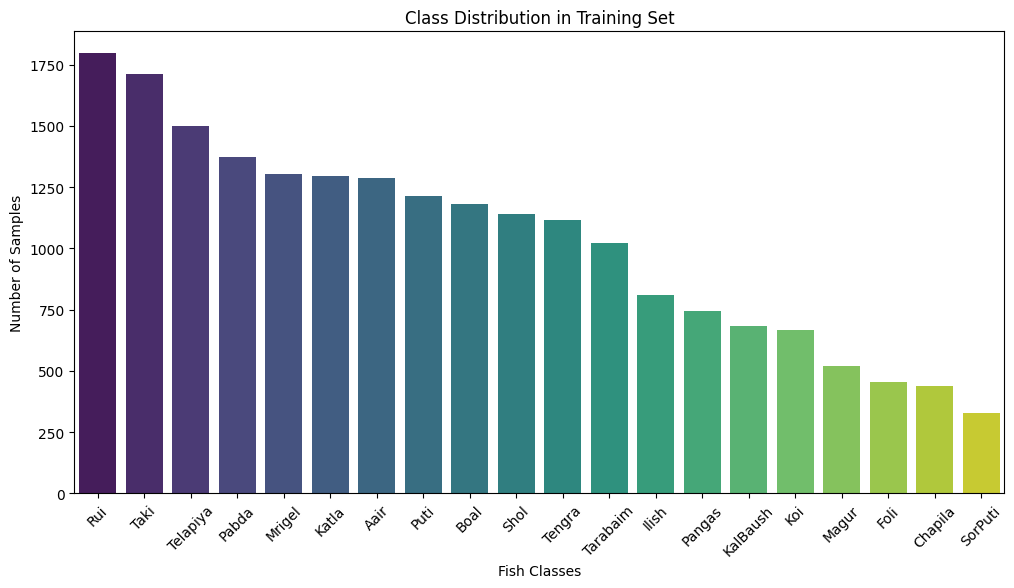

In [4]:
# =======================
# 5. Plot Class Distribution (Training set)
# =======================
labels = []
for c in class_names:
    class_path = os.path.join(train_dir, c)
    imgs = os.listdir(class_path)
    labels.extend([c]*len(imgs))

label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Fish Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.show()

In [5]:
# ==========================
# 2. Directory & Paths Setup
# ==========================
base_dir = r"D:\python\baseModel"
model_path = os.path.join(base_dir, "baseline_cnn_fish_best.h5")
final_model_path = os.path.join(base_dir, "baseline_cnn_fish_final.h5")
log_path = os.path.join(base_dir, "baseline_cnn_training_log.csv")

In [6]:
# ==========================
# 3. Build or Load Model
# ==========================
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

if os.path.exists(model_path):
    print("🔹 Loading previous best model...")
    model = load_model(model_path, compile=False)
else:
    print("🔹 Building new Baseline CNN model...")
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')   
    ])

optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


🔹 Building new Baseline CNN model...


c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,540 (42.62 MB)

 Trainable params: 11,171,540 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ==========================
# 4. Setup Callbacks
# ==========================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
csv_logger = CSVLogger(log_path, append=True)  
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)


In [8]:
# 5. Train Model
# ==========================
history = model.fit(
    train_gen,                
    validation_data=val_gen,   
    epochs=35,
    callbacks=[early_stop, csv_logger, checkpoint]
)


c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35


c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1250 - loss: 2.7997
Epoch 1: val_loss improved from None to 2.17810, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1459s 2s/step - accuracy: 0.1692 - loss: 2.6391 - val_accuracy: 0.3506 - val_loss: 2.1781
Epoch 2/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2805 - loss: 2.2663
Epoch 2: val_loss improved from 2.17810 to 1.79889, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1504s 2s/step - accuracy: 0.3000 - loss: 2.1991 - val_accuracy: 0.4705 - val_loss: 1.7989
Epoch 3/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3574 - loss: 2.0118
Epoch 3: val_loss improved from 1.79889 to 1.54499, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1471s 2s/step - accuracy: 0.3749 - loss: 1.9474 - val_accuracy: 0.5641 - val_loss: 1.5450
Epoch 4/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4246 - loss: 1.7912
Epoch 4: val_loss improved from 1.54499 to 1.36246, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1423s 2s/step - accuracy: 0.4358 - loss: 1.7606 - val_accuracy: 0.6133 - val_loss: 1.3625
Epoch 5/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4645 - loss: 1.6548
Epoch 5: val_loss improved from 1.36246 to 1.31146, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1429s 2s/step - accuracy: 0.4742 - loss: 1.6238 - val_accuracy: 0.6669 - val_loss: 1.3115
Epoch 6/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5094 - loss: 1.5234
Epoch 6: val_loss improved from 1.31146 to 1.13173, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1290s 2s/step - accuracy: 0.5109 - loss: 1.5071 - val_accuracy: 0.6941 - val_loss: 1.1317
Epoch 7/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5338 - loss: 1.4258
Epoch 7: val_loss improved from 1.13173 to 1.04053, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1289s 2s/step - accuracy: 0.5369 - loss: 1.4219 - val_accuracy: 0.7132 - val_loss: 1.0405
Epoch 8/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5606 - loss: 1.3519
Epoch 8: val_loss improved from 1.04053 to 0.98848, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1289s 2s/step - accuracy: 0.5647 - loss: 1.3358 - val_accuracy: 0.7314 - val_loss: 0.9885
Epoch 9/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5721 - loss: 1.2923
Epoch 9: val_loss improved from 0.98848 to 0.91890, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1286s 2s/step - accuracy: 0.5791 - loss: 1.2820 - val_accuracy: 0.7461 - val_loss: 0.9189
Epoch 10/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5953 - loss: 1.2230
Epoch 10: val_loss improved from 0.91890 to 0.87388, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1317s 2s/step - accuracy: 0.6020 - loss: 1.2109 - val_accuracy: 0.7675 - val_loss: 0.8739
Epoch 11/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6171 - loss: 1.1566
Epoch 11: val_loss improved from 0.87388 to 0.78358, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1306s 2s/step - accuracy: 0.6198 - loss: 1.1448 - val_accuracy: 0.7893 - val_loss: 0.7836
Epoch 12/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6431 - loss: 1.0906
Epoch 12: val_loss did not improve from 0.78358
644/644 ━━━━━━━━━━━━━━━━━━━━ 1285s 2s/step - accuracy: 0.6406 - loss: 1.0931 - val_accuracy: 0.7839 - val_loss: 0.7864
Epoch 13/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6611 - loss: 1.0307
Epoch 13: val_loss improved from 0.78358 to 0.71515, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1299s 2s/step - accuracy: 0.6569 - loss: 1.0311 - val_accuracy: 0.7956 - val_loss: 0.7152
Epoch 14/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6666 - loss: 0.9984
Epoch 14: val_loss improved from 0.71515 to 0.69295, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1313s 2s/step - accuracy: 0.6726 - loss: 0.9867 - val_accuracy: 0.8099 - val_loss: 0.6930
Epoch 15/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6878 - loss: 0.9396
Epoch 15: val_loss improved from 0.69295 to 0.66110, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.6847 - loss: 0.9328 - val_accuracy: 0.8161 - val_loss: 0.6611
Epoch 16/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7076 - loss: 0.8871
Epoch 16: val_loss did not improve from 0.66110
644/644 ━━━━━━━━━━━━━━━━━━━━ 1286s 2s/step - accuracy: 0.7027 - loss: 0.8926 - val_accuracy: 0.8110 - val_loss: 0.6762
Epoch 17/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7052 - loss: 0.8679
Epoch 17: val_loss improved from 0.66110 to 0.61700, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.7060 - loss: 0.8682 - val_accuracy: 0.8270 - val_loss: 0.6170
Epoch 18/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7211 - loss: 0.8239
Epoch 18: val_loss improved from 0.61700 to 0.60013, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.7179 - loss: 0.8307 - val_accuracy: 0.8289 - val_loss: 0.6001
Epoch 19/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7300 - loss: 0.7935
Epoch 19: val_loss improved from 0.60013 to 0.56175, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1293s 2s/step - accuracy: 0.7368 - loss: 0.7809 - val_accuracy: 0.8364 - val_loss: 0.5618
Epoch 20/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7533 - loss: 0.7289
Epoch 20: val_loss improved from 0.56175 to 0.52749, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.7456 - loss: 0.7488 - val_accuracy: 0.8447 - val_loss: 0.5275
Epoch 21/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7491 - loss: 0.7273
Epoch 21: val_loss did not improve from 0.52749
644/644 ━━━━━━━━━━━━━━━━━━━━ 1319s 2s/step - accuracy: 0.7531 - loss: 0.7235 - val_accuracy: 0.8484 - val_loss: 0.5303
Epoch 22/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7584 - loss: 0.7077
Epoch 22: val_loss improved from 0.52749 to 0.50836, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1337s 2s/step - accuracy: 0.7604 - loss: 0.7019 - val_accuracy: 0.8535 - val_loss: 0.5084
Epoch 23/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7719 - loss: 0.6681
Epoch 23: val_loss improved from 0.50836 to 0.50358, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1456s 2s/step - accuracy: 0.7701 - loss: 0.6653 - val_accuracy: 0.8525 - val_loss: 0.5036
Epoch 24/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7863 - loss: 0.6251
Epoch 24: val_loss did not improve from 0.50358
644/644 ━━━━━━━━━━━━━━━━━━━━ 1560s 2s/step - accuracy: 0.7803 - loss: 0.6414 - val_accuracy: 0.8534 - val_loss: 0.5086
Epoch 25/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7860 - loss: 0.6268
Epoch 25: val_loss improved from 0.50358 to 0.47561, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1485s 2s/step - accuracy: 0.7842 - loss: 0.6294 - val_accuracy: 0.8658 - val_loss: 0.4756
Epoch 26/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7948 - loss: 0.5906
Epoch 26: val_loss improved from 0.47561 to 0.47411, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1292s 2s/step - accuracy: 0.7947 - loss: 0.5983 - val_accuracy: 0.8676 - val_loss: 0.4741
Epoch 27/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8031 - loss: 0.5663
Epoch 27: val_loss improved from 0.47411 to 0.46727, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1300s 2s/step - accuracy: 0.7994 - loss: 0.5732 - val_accuracy: 0.8646 - val_loss: 0.4673
Epoch 28/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8080 - loss: 0.5581
Epoch 28: val_loss did not improve from 0.46727
644/644 ━━━━━━━━━━━━━━━━━━━━ 1288s 2s/step - accuracy: 0.8068 - loss: 0.5571 - val_accuracy: 0.8590 - val_loss: 0.4821
Epoch 29/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8034 - loss: 0.5564
Epoch 29: val_loss improved from 0.46727 to 0.45716, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1315s 2s/step - accuracy: 0.8082 - loss: 0.5467 - val_accuracy: 0.8720 - val_loss: 0.4572
Epoch 30/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8193 - loss: 0.5139
Epoch 30: val_loss improved from 0.45716 to 0.45553, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1289s 2s/step - accuracy: 0.8159 - loss: 0.5250 - val_accuracy: 0.8703 - val_loss: 0.4555
Epoch 31/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8215 - loss: 0.5102
Epoch 31: val_loss improved from 0.45553 to 0.45425, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1300s 2s/step - accuracy: 0.8182 - loss: 0.5120 - val_accuracy: 0.8727 - val_loss: 0.4543
Epoch 32/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8257 - loss: 0.4902
Epoch 32: val_loss improved from 0.45425 to 0.44064, saving model to D:\python\baseModel\baseline_cnn_fish_best.h5


644/644 ━━━━━━━━━━━━━━━━━━━━ 1288s 2s/step - accuracy: 0.8275 - loss: 0.4885 - val_accuracy: 0.8773 - val_loss: 0.4406
Epoch 33/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8340 - loss: 0.4663
Epoch 33: val_loss did not improve from 0.44064
644/644 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.8318 - loss: 0.4735 - val_accuracy: 0.8756 - val_loss: 0.4471
Epoch 34/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8373 - loss: 0.4550
Epoch 34: val_loss did not improve from 0.44064
644/644 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.8342 - loss: 0.4676 - val_accuracy: 0.8714 - val_loss: 0.4655
Epoch 35/35
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8346 - loss: 0.4600
Epoch 35: val_loss did not improve from 0.44064
644/644 ━━━━━━━━━━━━━━━━━━━━ 1359s 2s/step - accuracy: 0.8331 - loss: 0.4652 - val_accuracy: 0.8736 - val_loss: 0.4509


In [21]:
# ==========================
# 6. Save Final Model
# ==========================
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

✅ Final model saved to: D:\python\baseModel\baseline_cnn_fish_final.h5


In [22]:
# =======================
# 10. Evaluate on Test Data
# =======================
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n✅ Testing Accuracy : {test_acc*100:.2f}%")
print(f"✅ Testing Loss     : {test_loss:.4f}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 595ms/step - accuracy: 0.8824 - loss: 0.4213

✅ Testing Accuracy : 88.24%
✅ Testing Loss     : 0.4213


In [23]:

# ==========================
#  Evaluate on Validation Data
# ==========================
print("\n🔹 Evaluating model on validation dataset...")
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"✅ Validation Accuracy : {val_acc*100:.2f}%")
print(f"✅ Validation Loss     : {val_loss:.4f}")



🔹 Evaluating model on validation dataset...
184/184 ━━━━━━━━━━━━━━━━━━━━ 105s 568ms/step - accuracy: 0.8773 - loss: 0.4406
✅ Validation Accuracy : 87.73%
✅ Validation Loss     : 0.4406


In [24]:
train_loss, train_acc = model.evaluate(train_gen, verbose=1)
print(f"\n train Accuracy : {train_acc*100:.2f}%")
print(f" train Loss     : {train_loss:.4f}")

644/644 ━━━━━━━━━━━━━━━━━━━━ 331s 513ms/step - accuracy: 0.9676 - loss: 0.1369

 train Accuracy : 96.76%
 train Loss     : 0.1369


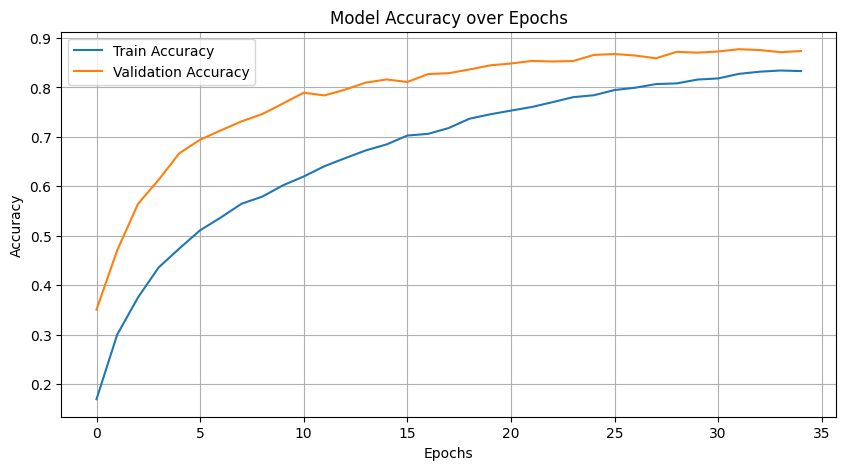

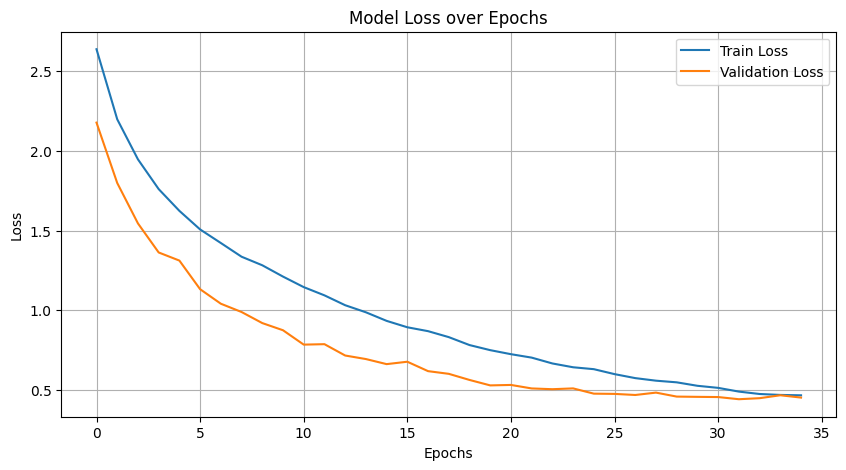

📊 Training log saved at: D:\python\baseModel\baseline_cnn_training_log.csv


In [25]:
# ==========================
# 7. Plot Training History
# ==========================
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"📊 Training log saved at: {log_path}")

92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 542ms/step

📊 Classification Report:

              precision    recall  f1-score   support

        Aair     0.8838    0.9511    0.9162       184
        Boal     0.8807    0.9172    0.8986       169
     Chapila     0.9400    0.7581    0.8393        62
        Foli     0.9630    0.8000    0.8739        65
       Ilish     0.9027    0.8793    0.8908       116
    KalBaush     0.9130    0.8571    0.8842        98
       Katla     0.8743    0.9027    0.8883       185
         Koi     0.8953    0.8105    0.8508        95
       Magur     0.8333    0.7432    0.7857        74
      Mrigel     0.9672    0.9516    0.9593       186
       Pabda     0.8614    0.8878    0.8744       196
      Pangas     0.9167    0.9252    0.9209       107
        Puti     0.9181    0.9023    0.9101       174
         Rui     0.8708    0.9183    0.8939       257
        Shol     0.8452    0.8037    0.8239       163
     SorPuti     0.9286    0.8298    0.8764        47
        Taki

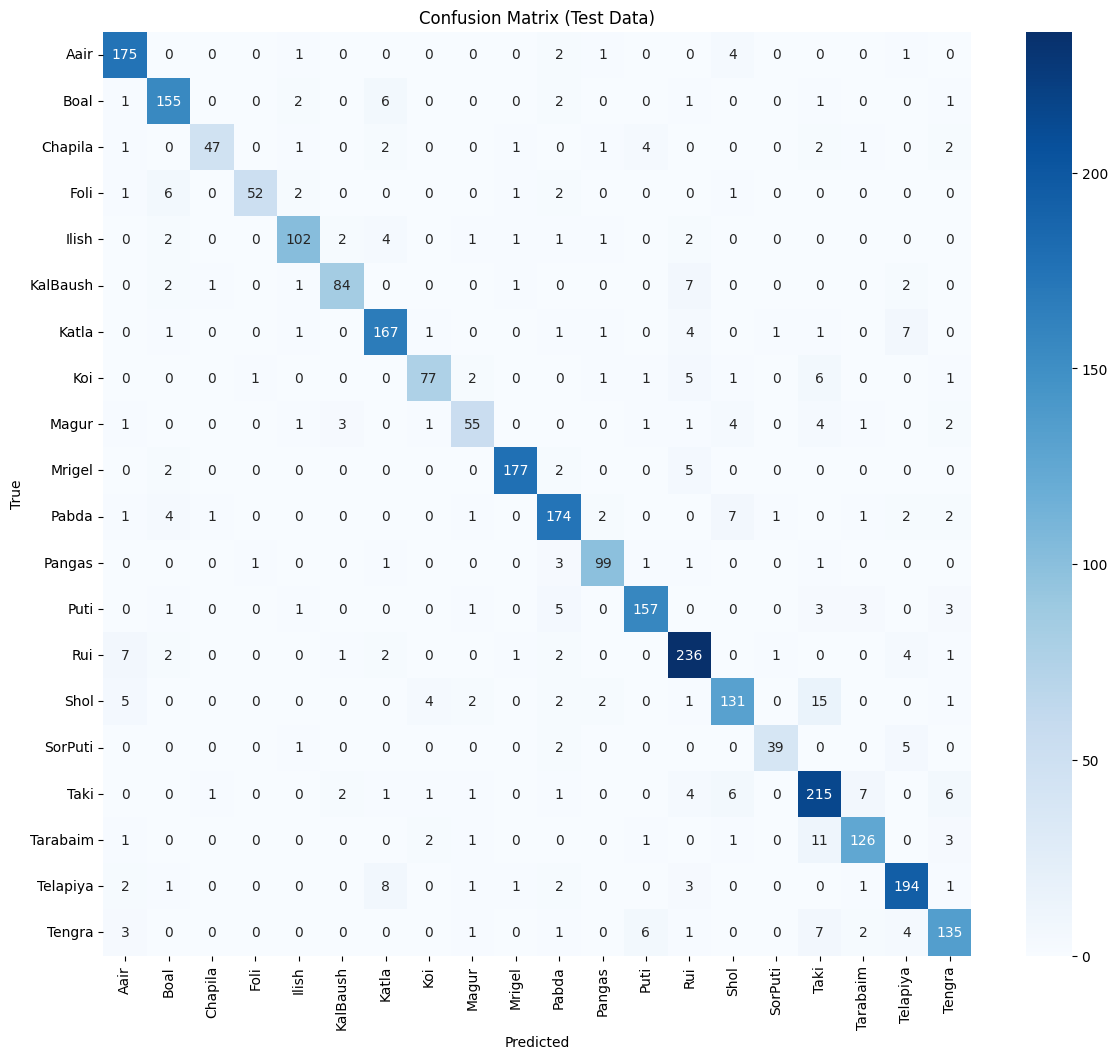

In [14]:
# =======================
# 11. Predictions
# =======================
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("\n📊 Classification Report:\n")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    digits=4
))

# =======================
# 12. Confusion Matrix
# =======================
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Data)")
plt.show()



📊 Per-Class Metrics:

          Precision  Recall  F1-Score
Class                                
Aair         0.8838  0.9511    0.9162
Boal         0.8807  0.9172    0.8986
Chapila      0.9400  0.7581    0.8393
Foli         0.9630  0.8000    0.8739
Ilish        0.9027  0.8793    0.8908
KalBaush     0.9130  0.8571    0.8842
Katla        0.8743  0.9027    0.8883
Koi          0.8953  0.8105    0.8508
Magur        0.8333  0.7432    0.7857
Mrigel       0.9672  0.9516    0.9593
Pabda        0.8614  0.8878    0.8744
Pangas       0.9167  0.9252    0.9209
Puti         0.9181  0.9023    0.9101
Rui          0.8708  0.9183    0.8939
Shol         0.8452  0.8037    0.8239
SorPuti      0.9286  0.8298    0.8764
Taki         0.8083  0.8776    0.8415
Tarabaim     0.8873  0.8630    0.8750
Telapiya     0.8858  0.9065    0.8961
Tengra       0.8544  0.8438    0.8491


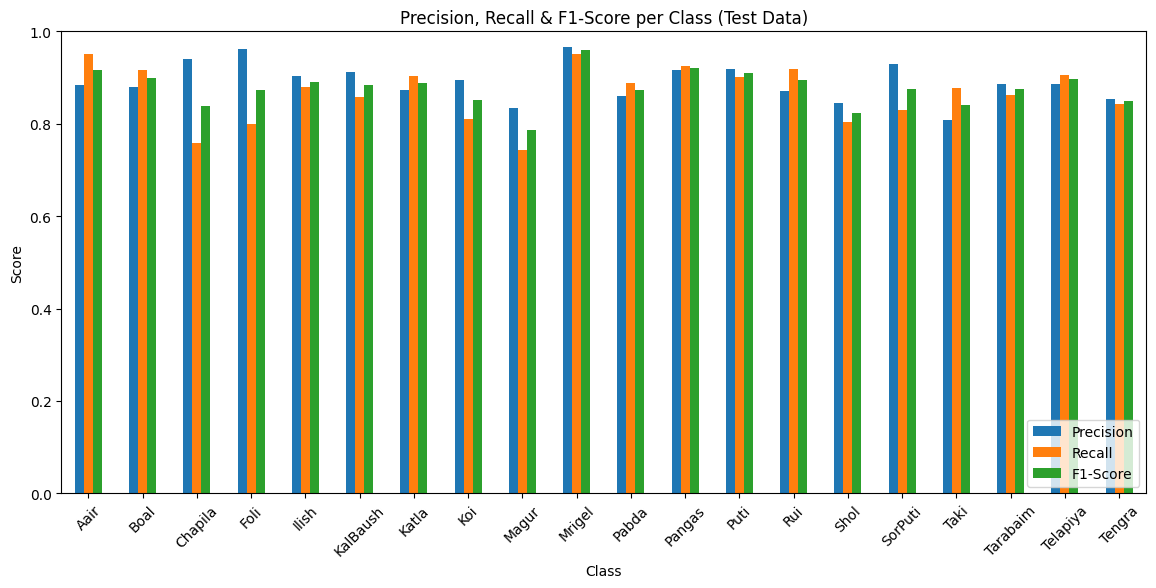

In [15]:
# =======================
# 13. Precision, Recall, F1 Score per Class
# =======================
precision = precision_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
recall    = recall_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))
f1        = f1_score(y_true, y_pred_classes, average=None, labels=range(len(class_names)))

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).set_index('Class')

print("\n📊 Per-Class Metrics:\n")
print(metrics_df.round(4))

metrics_df.plot(kind='bar', figsize=(14,6))
plt.title("Precision, Recall & F1-Score per Class (Test Data)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


In [16]:
# =======================
# 17. Save JSON Summary (For Comparison)
# =======================
import json
import numpy as np
import os


output_dir = r"C:\Users\Hp\Desktop\dataset\margeDataset\output"
os.makedirs(output_dir, exist_ok=True)

results = {
    "dataset": "BangladeshDeltaFish",
    "model": "Baseline CNN",
    "train_acc": float(history.history['accuracy'][-1]),
    "val_acc": float(history.history['val_accuracy'][-1]),
    "test_acc": float(test_acc),
    "precision": float(np.mean(precision)),
    "recall": float(np.mean(recall)),
    "f1": float(np.mean(f1))
}


json_path = os.path.join(output_dir, "results_summary.json")

with open(json_path, "w") as f:
    json.dump(results, f, indent=4)

print(f" JSON summary saved successfully at: {json_path}")
print(json.dumps(results, indent=4))


 JSON summary saved successfully at: C:\Users\Hp\Desktop\dataset\margeDataset\output\results_summary.json
{
    "dataset": "BangladeshDeltaFish",
    "model": "Baseline CNN",
    "train_acc": 0.8330824971199036,
    "val_acc": 0.8735768795013428,
    "test_acc": 0.8824328780174255,
    "precision": 0.8915027491063492,
    "recall": 0.8664375064432648,
    "f1": 0.8774277576059806
}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


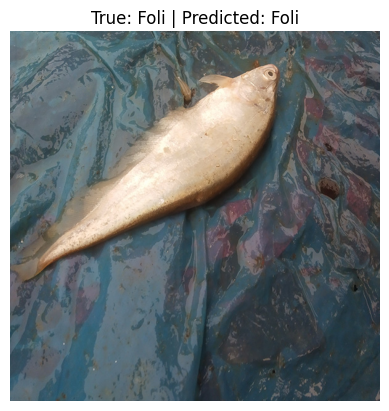

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


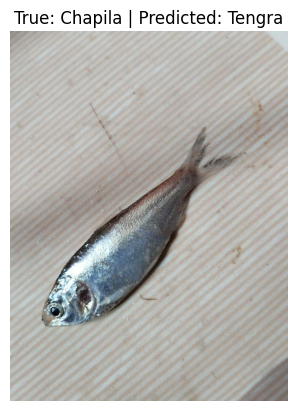

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


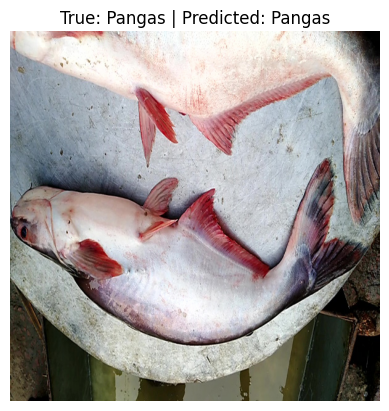

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


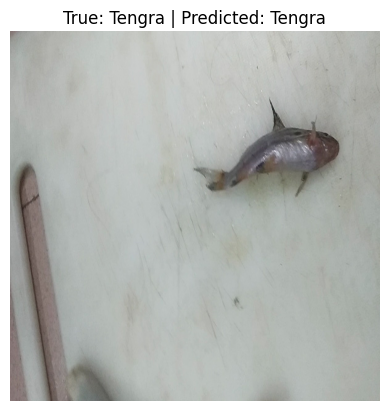

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


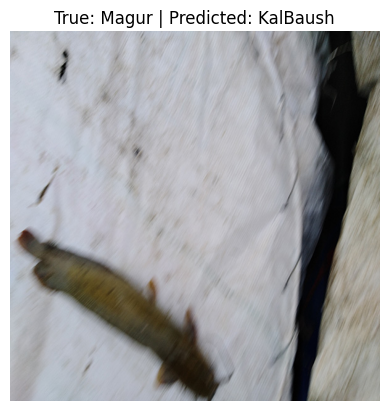

In [17]:
# =======================
# 14. Predict Random Test Images
# =======================
import random
from tensorflow.keras.utils import load_img, img_to_array

def predict_random_image(test_dir, model, class_names, img_size=(224,224)):
    random_class = random.choice(os.listdir(test_dir))
    class_path = os.path.join(test_dir, random_class)
    random_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, random_img)

    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]
    true_class = random_class

    plt.imshow(load_img(img_path))
    plt.axis("off")
    plt.title(f"True: {true_class} | Predicted: {pred_class}")
    plt.show()


# Run 5 random predictions
for i in range(5):
    predict_random_image(test_dir, model, class_names)


In [18]:
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# =======================
# 15. Predict a Specific Image
# =======================
def predict_single_image(img_path, model, class_names, img_size=(224,224)):
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred)]

    plt.imshow(load_img(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {pred_class}")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


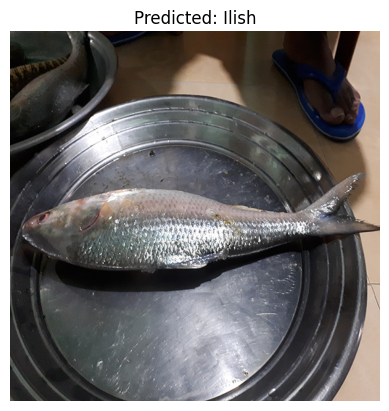

In [19]:
img_path = r"C:\Users\Hp\Desktop\dataset\margeDataset\test\Ilish\Ilish17.jpg"
predict_single_image(img_path, model, class_names, img_size=(224,224))
